# SOAP example

To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=ON ..
+ make -j 4
+ make install

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import sys
import time
sys.path.insert(0,'../build/')
sys.path.insert(0,'../build/bindings/')
import rascal
import rascal.lib as lrl
import json
import ase
from ase.visualize import view
import numpy as np
import sys

In [4]:
test_hypers = {"interaction_cutoff": 3.5,
               "cutoff_smooth_width": 0.5, 
               "max_radial": 6,
               "max_angular": 6,
               "gaussian_sigma_type": "Constant",
               "gaussian_sigma_constant": 0.3}

nmax = test_hypers["max_radial"]
lmax = test_hypers["max_angular"]

In [5]:
frames = ase.io.read('../tests/reference_data/coords_benzene_dimer_1000.xyz',':3')

In [7]:
frames[0].get_pbc()

array([False, False, False])

In [17]:
with lrl._rascal.utils.ostream_redirect():
    sph_expn = rascal.representation.SphericalExpansion(**test_hypers)

In [ ]:
with lrl._rascal.utils.ostream_redirect():
    expansions = sph_expn.transform(frames)

In [13]:
X = expansions.get_feature_matrix().T
X.shape

(42, 1176)

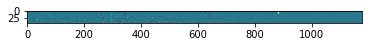

In [14]:
plt.imshow(X)

In [15]:
start = time.time()

frames = ase.io.read('../tests/reference_data/dft-smiles_500.xyz',':')

with lrl._rascal.utils.ostream_redirect():
    sph_expn = rascal.representation.SphericalExpansion(**test_hypers)

with lrl._rascal.utils.ostream_redirect():
    expansions = sph_expn.transform(frames)
    
X = expansions.get_feature_matrix().T
ncen = len(X)
coeffs = np.zeros((ncen,nmax,lmax+1,2*lmax+1),float)
for icen in range(ncen):
    ii=0
    for l in range(lmax+1):
        for im in range(2*l+1):
            for n in range(nmax):
                coeffs[icen,n,l,im] = X[icen,ii]
                ii+=1

size = nmax*nmax*(lmax+1)
power = np.zeros((ncen,size),float)
for icen in range(ncen):
    jj = 0
    for n1 in range(nmax):
        for n2 in range(nmax):
            for l in range(lmax+1):
                power[icen,jj] = np.dot(coeffs[icen,n1,l],coeffs[icen,n2,l])/np.sqrt(2*l+1)
                jj+=1
    #power[icen] /= np.linalg.norm(power[icen])

kernel = np.dot(power,power.T)

print(time.time()-start)

9.493845224380493


In [5]:
coeffs = np.zeros((ncen,nmax,lmax+1,2*lmax+1),float)
for icen in range(ncen):
    ii=0
    for l in range(lmax+1):
        for im in range(2*l+1):
            for n in range(nmax):
                coeffs[icen,n,l,im] = X[icen,ii]
                ii+=1

coeffs[0,:,2,:5]

array([[ 5.99250029e-05,  4.31807799e-04, -1.21774221e-03,
        -1.29635795e-04,  1.19578349e-03],
       [ 2.22954697e-04,  1.60449776e-03, -4.52487890e-03,
        -4.81585084e-04,  4.44327129e-03],
       [ 2.98078695e-04,  2.13352241e-03, -6.01696633e-03,
        -6.39744203e-04,  5.90837252e-03],
       [ 1.54920681e-05,  1.09453716e-04, -3.08703228e-04,
        -3.27424255e-05,  3.03122352e-04],
       [ 2.75769407e-05,  1.97498199e-04, -5.56983302e-04,
        -5.92267128e-05,  5.46931655e-04],
       [-1.27874016e-05, -9.17615481e-05,  2.58782666e-04,
         2.75277498e-05, -2.54113717e-04],
       [ 4.98589767e-06,  3.58060257e-05, -1.00978472e-04,
        -1.07430192e-05,  9.91568020e-05],
       [-1.06013927e-06, -7.61608492e-06,  2.14784839e-05,
         2.28523110e-06, -2.10910262e-05]])

In [6]:
size = nmax*nmax*(lmax+1)
power = np.zeros((ncen,size),float)
for icen in range(ncen):
    jj = 0
    for n1 in range(nmax):
        for n2 in range(nmax):
            for l in range(lmax+1):
                power[icen,jj] = np.dot(coeffs[icen,n1,l],coeffs[icen,n2,l])/np.sqrt(2*l+1)
                jj+=1
    power[icen] /= np.linalg.norm(power[icen])
kernel = np.dot(power,power.T)
kernel

/local/ssd/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


array([[1.00000000e+00, 1.17696848e-03, 2.71214550e-04, ...,
        3.16165769e-02, 3.61678602e-02, 3.09570661e-02],
       [1.17696848e-03, 1.00000000e+00, 1.15191581e-01, ...,
        1.45157326e-01, 7.66723577e-02, 1.47244452e-01],
       [2.71214550e-04, 1.15191581e-01, 1.00000000e+00, ...,
        1.99051948e-01, 2.10444425e-02, 1.35982990e-01],
       ...,
       [3.16165769e-02, 1.45157326e-01, 1.99051948e-01, ...,
        1.00000000e+00, 8.45890392e-01, 9.63581071e-01],
       [3.61678602e-02, 7.66723577e-02, 2.10444425e-02, ...,
        8.45890392e-01, 1.00000000e+00, 9.18693812e-01],
       [3.09570661e-02, 1.47244452e-01, 1.35982990e-01, ...,
        9.63581071e-01, 9.18693812e-01, 1.00000000e+00]])